## Введение

Основная сложность работы с такими рядами, как в нашем проекте, заключается в том, как учесть сложную структуру сезонности — суточной, недельной и годовой. В рамках моделей ARIMA можно учесть только одну из них. Обычно в таких случаях сезонность с самым маленьким периодом явно моделируют с помощью аримы, а все остальные учитывают за счёт регрессионной компоненты.

Для учёта недельной сезонности используются регрессионные признаки следующего вида:

<center>$s_{i}=\sin([1,…,T]∗2πi/168), c_{i}=\cos([1,…,T]∗2πi/168), i=1,…,K.$</center>

Здесь $T$ — это длина моделируемого ряда, 168 — длительность недели в часах, а значение параметра $K$ вам предстоит подобрать самостоятельно (в зависимости от длины подготовленного ряда, можно для начала взять $K$ равным 2-5).

Если вы собрали данные за несколько лет, аналогичные признаки можно использовать для учёта годовой сезонности. Длина года — 8766 часов.

Если в данных есть линейный или описываемый ещё какой-то простой функцией $f$ тренд, стоит добавить к регрессионным признакам вектор $[1,…,T]$ или, соответственно, $f([1,…,T])$.

Если вы забыли, как в statsmodels работать с моделями ARIMA, почитайте [туториал](https://github.com/statsmodels/statsmodels/blob/master/examples/notebooks/statespace_sarimax_stata.ipynb) от создателей.

## Задание № 1

Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. **Не используйте данные за последний имеющийся месяц — июнь 2016!** Создайте регрессионные признаки для учёта сезонностей и трендов.

In [1]:
import pandas as pd
import numpy as np
from glob import glob

Перед открытием данных, необходимо получить список всех имеющихся файлов. 

In [2]:
file_path = glob("u_data/*.csv", recursive=True)
file_path = np.sort(file_path)[:-12]
print(file_path)

['u_data/yellow_tripdata_2009-01.csv' 'u_data/yellow_tripdata_2009-02.csv'
 'u_data/yellow_tripdata_2009-03.csv' 'u_data/yellow_tripdata_2009-04.csv'
 'u_data/yellow_tripdata_2009-05.csv' 'u_data/yellow_tripdata_2009-06.csv'
 'u_data/yellow_tripdata_2009-07.csv' 'u_data/yellow_tripdata_2009-08.csv'
 'u_data/yellow_tripdata_2009-09.csv' 'u_data/yellow_tripdata_2009-10.csv'
 'u_data/yellow_tripdata_2009-11.csv' 'u_data/yellow_tripdata_2009-12.csv'
 'u_data/yellow_tripdata_2010-01.csv' 'u_data/yellow_tripdata_2010-02.csv'
 'u_data/yellow_tripdata_2010-03.csv' 'u_data/yellow_tripdata_2010-04.csv'
 'u_data/yellow_tripdata_2010-05.csv' 'u_data/yellow_tripdata_2010-06.csv'
 'u_data/yellow_tripdata_2010-07.csv' 'u_data/yellow_tripdata_2010-08.csv'
 'u_data/yellow_tripdata_2010-09.csv' 'u_data/yellow_tripdata_2010-10.csv'
 'u_data/yellow_tripdata_2010-11.csv' 'u_data/yellow_tripdata_2010-12.csv'
 'u_data/yellow_tripdata_2011-01.csv' 'u_data/yellow_tripdata_2011-02.csv'
 'u_data/yellow_tripdata_

Далее, необходимо реализовать функцию, которая будет поочередно открывать каждый файл, и в конечном счете объединит все данные в единую выборку.

In [3]:
def open_data(path):
    data_list = []
    for p in path:
        data = pd.read_csv(p, sep=",", index_col="time", parse_dates=["time"])
        data_list.append(data)
    return pd.concat(data_list)

In [4]:
data_orig = open_data(file_path)

In [5]:
data = data_orig.iloc[:]

После получения всех данных, следует извлечь из них информацию по любому интересующиму нас региону. 

В моем случае, это регион под номером **1126**.

In [6]:
data = data[data.region == 1126].drop(["region"], axis=1)

После того, как разобрались с данными, следует посмотреть на график распределения поездкок на всем временном интервале.

In [7]:
import matplotlib.pyplot as plt

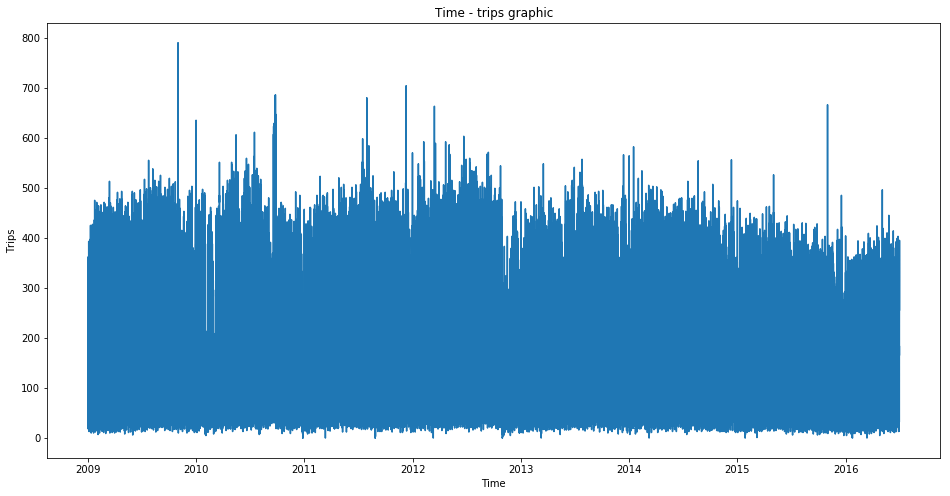

In [8]:
plt.figure(figsize=(16, 8))
plt.plot(data.index, data.trips)
plt.xlabel("Time")
plt.ylabel("Trips")
plt.title("Time - trips graphic")
plt.show()

Сложно изучать такой график, поэтому для начала попробуем отобразить график за первый месяц 2009 года.

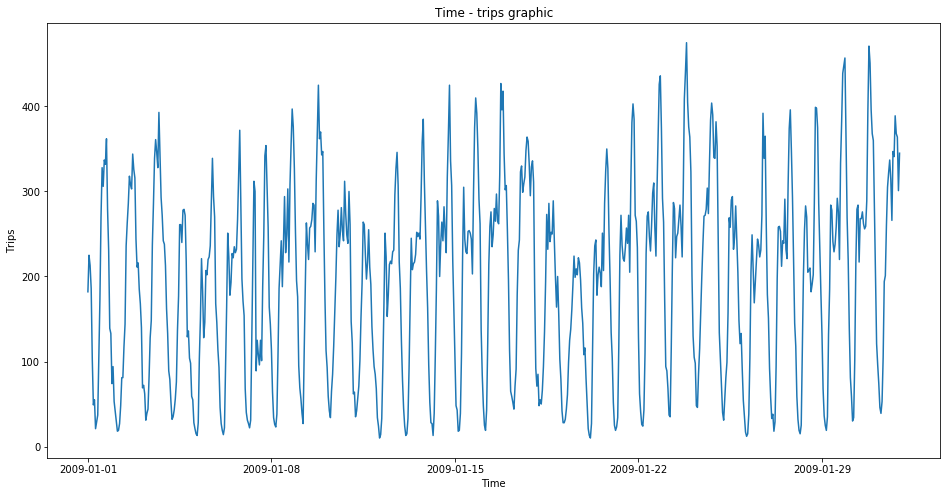

In [9]:
hours_2009 = 31 * 24

plt.figure(figsize=(16, 8))
plt.plot(data.index[:hours_2009], data.trips[:hours_2009])
plt.xlabel("Time")
plt.ylabel("Trips")
plt.title("Time - trips graphic")
plt.show()

Можно заметить, что на графиках присутствует недельная сезонность. Поэтому имеет смысл построить регрессионный признак по формулам, указанным во введении.

<center>$s_{i}=\sin([1,…,T]∗2πi/168), c_{i}=\cos([1,…,T]∗2πi/168), i=1,…,K.$</center>

Где $T$ — это длина моделируемого ряда, 168 — длительность недели в часах, а значение параметра $K$ вам предстоит подобрать самостоятельно (в зависимости от длины подготовленного ряда, можно для начала взять $K$ равным 2-5).

In [10]:
# Функция построения регрессионного признака по формулам синуса и косинуса

def season_attribute(func_name, start_T, T, season_length, season_name, K):
    if func_name not in ["sin", "cos"]:
        raise ValueError("Set func_name the value is sin or cos")
    
    func = np.sin if func_name is "sin" else np.cos
    t_interval = np.arange(start_T, T + 1, dtype=int)
    values_dict = dict()
    for k in range(1, K + 1):
        key = func_name + "_" + season_name + "_" + str(k)
        values_dict[key] = func(t_interval * 2 * np.pi * k / season_length)
    return pd.DataFrame(values_dict)

In [11]:
data = data_orig.iloc[:]
data = data[data.region == 1126].drop(["region"], axis=1)

In [13]:
# Установка значения K
K = 2

# Регрессионные признаки по дневной сезонности
day_hours = 24
#sin_day_data = season_attribute("sin", data.shape[0], day_hours, "day", K).set_index(data.index)
#cos_day_data = season_attribute("cos", data.shape[0], day_hours, "day", K).set_index(data.index)

# Регрессионные признаки по недельной сезонности
week_hours = day_hours * 7
sin_week_data = season_attribute("sin", 1, data.shape[0], week_hours, "week", K).set_index(data.index)
cos_week_data = season_attribute("cos", 1, data.shape[0], week_hours, "week", K).set_index(data.index)

# Регрессионные признаки по месячной сезонности
month_hours = day_hours * 30
#sin_month_data = season_attribute("sin", data.shape[0], month_hours, "month", K).set_index(data.index)
#cos_month_data = season_attribute("cos", data.shape[0], month_hours, "month", K).set_index(data.index)

# Регрессионные признаки по годовой сезонности
#year_hours = day_hours * 365
year_hours = 8766
#sin_year_data = season_attribute("sin", data.shape[0], 168, "year", K).set_index(data.index)
#cos_year_data = season_attribute("cos", data.shape[0], 168, "year", K).set_index(data.index)

# Создание списка всех датасетов для объединения
#data_list = [data, sin_day_data, cos_day_data, sin_week_data, cos_week_data, sin_month_data,
#             cos_month_data, sin_year_data, cos_year_data]
#data_list = [data, sin_week_data, cos_week_data, sin_month_data,
#             cos_month_data, sin_year_data, cos_year_data]
data_list = [data, sin_week_data, cos_week_data]

data = pd.concat(data_list, axis=1)
data.head(5)

,trips,sin_week_1,sin_week_2,cos_week_1,cos_week_2
time,,,,,
2009-01-01 00:00:00,182.0,0.037391,0.074730,0.999301,0.997204
2009-01-01 01:00:00,225.0,0.074730,0.149042,0.997204,0.988831
2009-01-01 02:00:00,213.0,0.111964,0.222521,0.993712,0.974928
2009-01-01 03:00:00,186.0,0.149042,0.294755,0.988831,0.955573
2009-01-01 04:00:00,103.0,0.185912,0.365341,0.982566,0.930874


Так как данные содержат информацию по поездкам **с 2009 года по июнь 2016 года**, необходимо выделить из данных последний месяц, для формирования тестовой выборки.

In [14]:
# Количество часов в июне
june_hour_count = 30 * 24

train_data = data[:-june_hour_count]
test_data = data[-june_hour_count:]

## Задание № 2

Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.

In [15]:
import statsmodels.formula.api as smf

Определяем формулу для проведения регрессии целевого признака.

Для этого проводится выделение целевого признака из названия столбца датафрейма, а также всех признаков, расчитанных выше.

In [16]:
formula = train_data.columns[0] + " ~ "
formula_attr = " + ".join(train_data.columns[1:])
formula += formula_attr
del formula_attr
formula

'trips ~ sin_week_1 + sin_week_2 + cos_week_1 + cos_week_2'

In [17]:
estimator = smf.ols(formula, train_data)
fitted = estimator.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  trips   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     672.8
Date:                Sat, 18 Nov 2017   Prob (F-statistic):               0.00
Time:                        14:00:57   Log-Likelihood:            -4.0285e+05
No. Observations:               64992   AIC:                         8.057e+05
Df Residuals:                   64987   BIC:                         8.057e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    223.9080      0.467    479.504      0.0

Выше представлены результаты, полученные после обучения регрессионной модели.

Коэффициент детерминации ($R$) невысокий, что характеризует неполноту признакового пространства. Однако на графиках, представленных ниже, в остатках регрессии прослеживается суточная сезонность, что и являлось нашей целью.

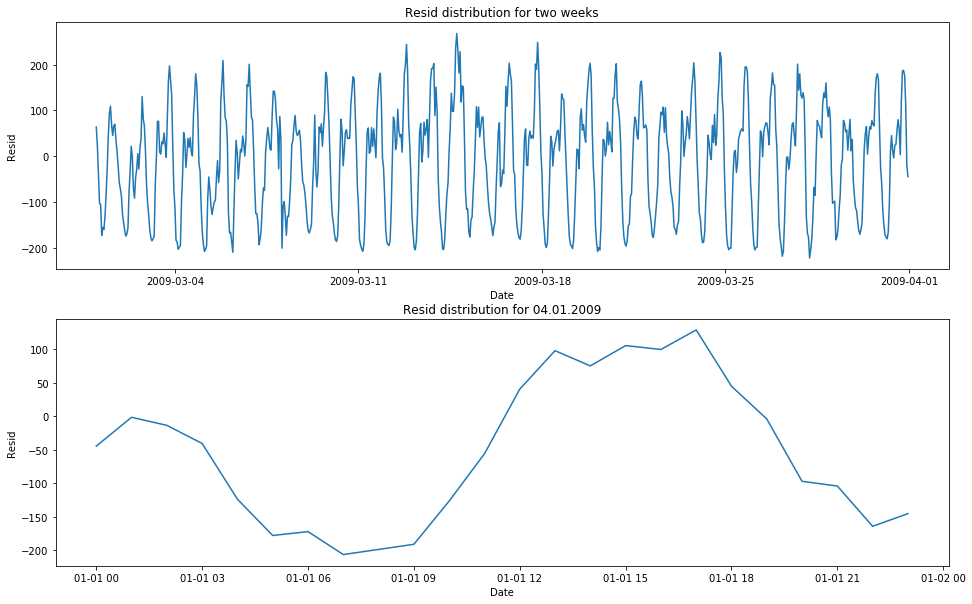

In [18]:
plt.figure(figsize=(16,10))
day_start = 59
days = 31
plt.subplot(211)
plt.plot(fitted.resid.index[day_hours * day_start:day_hours * (day_start + days)],
         fitted.resid[day_hours * day_start:day_hours * (day_start + days)])
plt.xlabel("Date")
plt.ylabel("Resid")
plt.title("Resid distribution for two weeks")

plt.subplot(212)
plt.plot(fitted.resid.index[:day_hours], fitted.resid[:day_hours])
plt.xlabel("Date")
plt.ylabel("Resid")
plt.title("Resid distribution for 04.01.2009")

plt.show()

На графике (указанном выше) ярко прослеживается суточная сезонность с некоторыми колебаниями амплитуды.

Однако очевидно, что повышение амплитуды связано, в первую очередь, с выходными днями. 

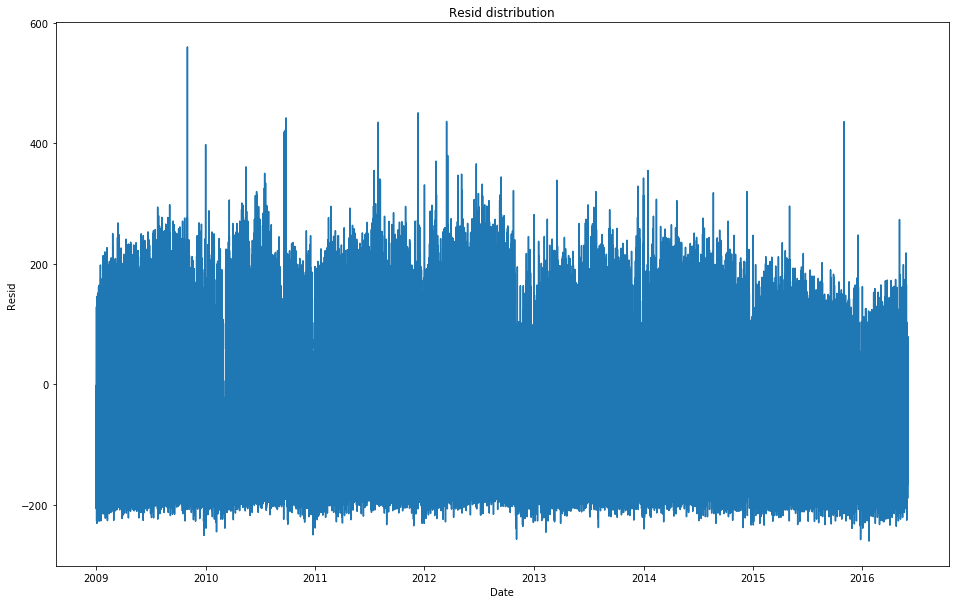

In [19]:
plt.figure(figsize=(16,10))
days = 14
plt.plot(fitted.resid.index, fitted.resid)
plt.xlabel("Date")
plt.ylabel("Resid")
plt.title("Resid distribution")
plt.show()

При наблюдении на график на всем интервале полученных данных, в первую очередь заметны периодические всплески. Предполагается, что причиной повышения амплитуды являются **праздники**, так как очевидно, что **выходные дни** имеют всплески меньшей амплитуды.

Также следует обратить внимание на годовую сезонность. В период **весна-лето** проявляется "горб", который характеризует повышение спроса такси.

Отмеченные выше наблюдения являются лишь малой частью того, что содержится в данных. Необходим более тщательный анализ временного ряда для построения качественной модели.

## Задание № 3

Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.

In [20]:
import statsmodels.api as sm

/Users/Ar4eBaT/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [21]:
resid = fitted.resid
post_diff = resid

Перед тем, как попытаться сделать ряд стационарным, необходимо проследить, как выглядят графики при сезонном разложении. В то же время, необходимо оценить ряд на стационарность критерием Дики-Фуллера. 

Критерий Дики-Фуллера 0.00000000


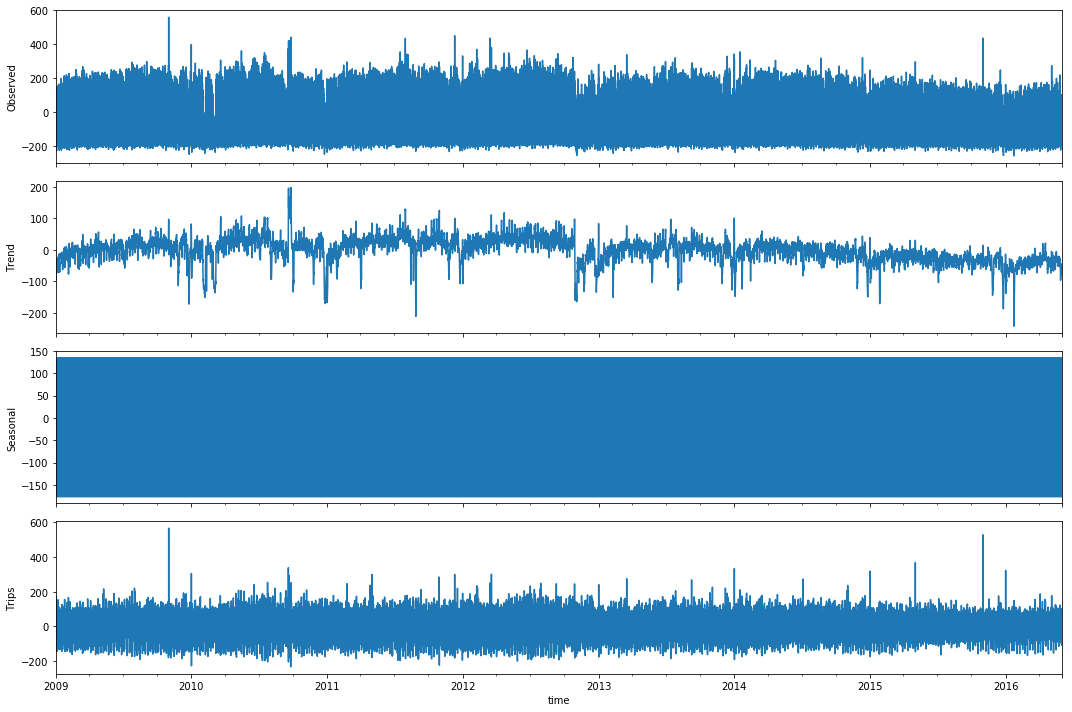

In [24]:
plt.figure(figsize(15,10))
s_dec = sm.tsa.seasonal_decompose(post_diff.dropna())
s_dec.plot()
print("Критерий Дики-Фуллера %.8f" % sm.tsa.stattools.adfuller(post_diff.dropna())[1])
plt.ylabel("Trips")
plt.show()

Оценивания график на наличие тренда, становится заметно, что выраженного тренда нет. В основном наблюдается "белый шум". 

Ко всему прочему, сезонность также сложно обнаружить. Ввиду того, что на графике он сливается воедино из-за визуальных ограничений. Далее, сезонность будет рассматриваться на отдельном временном интервале.

Что же касается теста Дики-Фуллера, то он отвергает гипотезу о нестационарности временного ряда, о чем свидетельствуют также и графики.

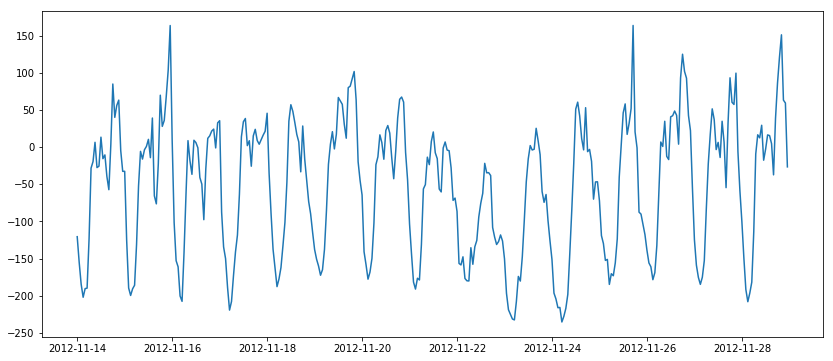

In [25]:
rand_day = np.random.randint(1, (s_dec.observed.shape[0] / 24) - 15)
n = 24 * rand_day
plt.figure(figsize(14,6))
plt.plot(s_dec.observed[n:n + 24 * 15])
plt.show()

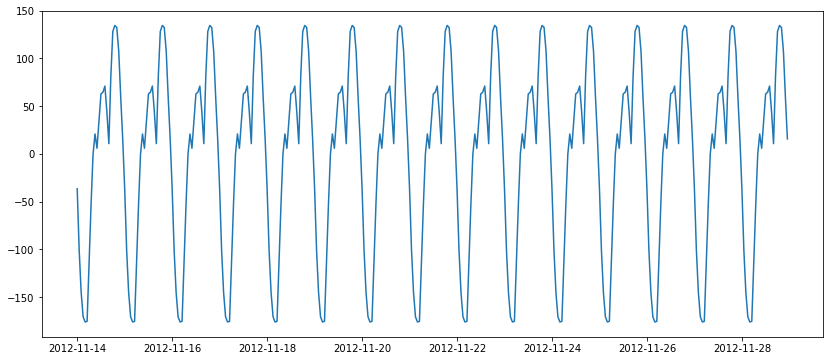

In [26]:
plt.figure(figsize(14,6))
plt.plot(s_dec.seasonal[n:n + 24 * 15])
plt.show()

Наконец, оценивая графики наблюдаемых значений и сезонной компоненты, наблюдается внешняя схожесть графиков, что свидетельствует об удачном выделении сезонности.

## Задание № 4

Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров p,q,P,Q. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.

In [23]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


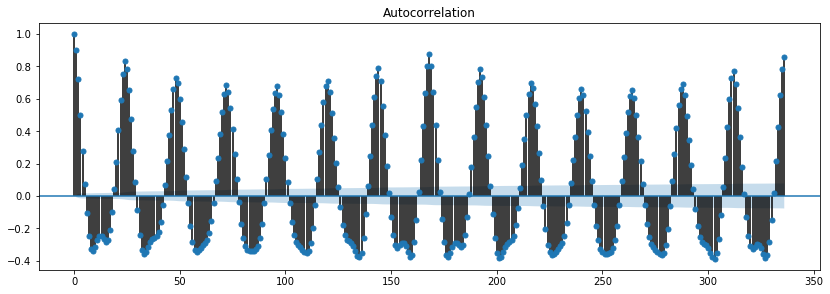

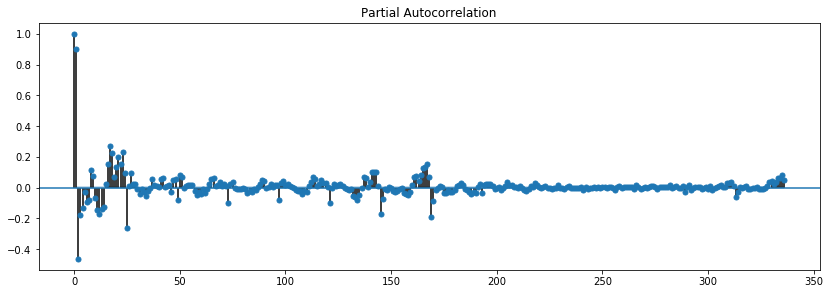

In [27]:
lags = 24 * 7 * 2

plt.figure(figsize=(14,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(post_diff.dropna().values.squeeze(), lags=lags, ax=ax)
plt.show()
plt.figure(figsize=(14,10))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(post_diff.dropna().values.squeeze(), lags=lags, ax=ax)
plt.show()

In [656]:
Q = range(0, 3)
q = range(0, 2)
P = range(0, 3)
p = range(0, 2)
D = 1
d = 1

## Задание № 5

Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов $K$ или поменять порядки дифференцирования.

In [379]:
from itertools import product

In [657]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [659]:
parameters_list

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 2, 2),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 0, 2),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 1, 1, 2),
 (0, 1, 2, 0),
 (0, 1, 2, 1),
 (0, 1, 2, 2),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 0, 2),
 (1, 0, 1, 0),
 (1, 0, 1, 1),
 (1, 0, 1, 2),
 (1, 0, 2, 0),
 (1, 0, 2, 1),
 (1, 0, 2, 2),
 (1, 1, 0, 0),
 (1, 1, 0, 1),
 (1, 1, 0, 2),
 (1, 1, 1, 0),
 (1, 1, 1, 1),
 (1, 1, 1, 2),
 (1, 1, 2, 0),
 (1, 1, 2, 1),
 (1, 1, 2, 2)]

In [742]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        print(param)
        model=sm.tsa.statespace.SARIMAX(train_data.trips, train_data.iloc[:,1:], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

(0, 0, 0, 0)
wrong parameters: (0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 0, 2)
(0, 0, 1, 0)
(0, 0, 1, 1)
(0, 0, 1, 2)
(0, 0, 2, 0)
(0, 0, 2, 1)
(0, 0, 2, 2)
(0, 1, 0, 0)
(0, 1, 0, 1)
(0, 1, 0, 2)
(0, 1, 1, 0)
(0, 1, 1, 1)
(0, 1, 1, 2)
(0, 1, 2, 0)
(0, 1, 2, 1)
(0, 1, 2, 2)
(1, 0, 0, 0)
(1, 0, 0, 1)
(1, 0, 0, 2)
(1, 0, 1, 0)
(1, 0, 1, 1)
(1, 0, 1, 2)
(1, 0, 2, 0)
(1, 0, 2, 1)
(1, 0, 2, 2)
(1, 1, 0, 0)
(1, 1, 0, 1)
(1, 1, 0, 2)
(1, 1, 1, 0)
(1, 1, 1, 1)
(1, 1, 1, 2)
(1, 1, 2, 0)
(1, 1, 2, 1)
(1, 1, 2, 2)
CPU times: user 17h 43min 55s, sys: 3h 36min 56s, total: 21h 20min 52s
Wall time: 1d 13h 39min 35s


In [743]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters            aic
34  (1, 1, 2, 2)  643686.584110
31  (1, 1, 1, 2)  646237.879256
16  (0, 1, 2, 2)  649489.408246
7   (0, 0, 2, 2)  649548.415579
25  (1, 0, 2, 2)  649680.561845


In [744]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              trips   No. Observations:                64992
Model:             SARIMAX(1, 1, 1)x(2, 1, 2, 12)   Log Likelihood             -321832.292
Date:                            Sat, 14 Oct 2017   AIC                         643686.584
Time:                                    13:17:47   BIC                         643786.486
Sample:                                01-01-2009   HQIC                        643717.501
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin_week_1    28.4315      1.358     20.943      0.000      25.771      31.092
sin_week_2   -14.8198      1.117   

## Задание № 6

Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.

In [745]:
from scipy import stats

Критерий Стьюдента: p=0.621322
Критерий Дики-Фуллера: p=0.000000


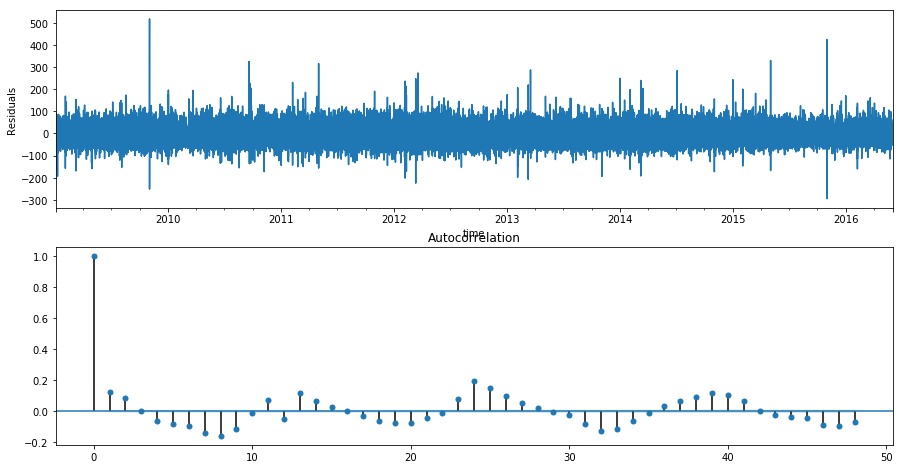

In [746]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

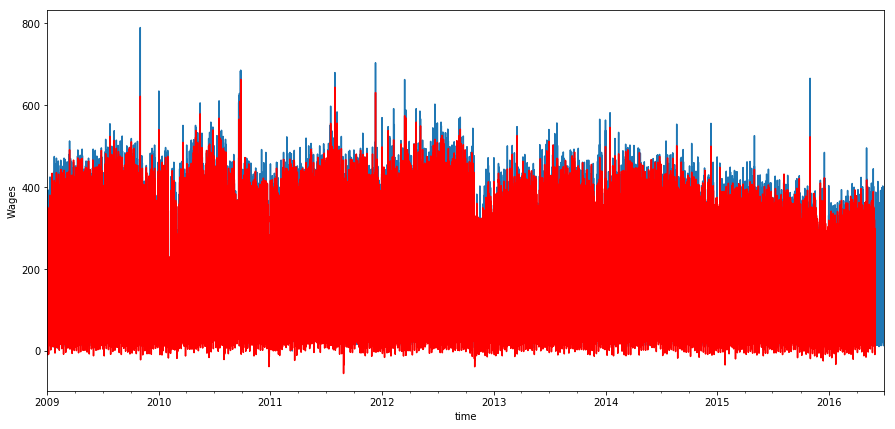

In [747]:
data['model'] = best_model.fittedvalues
plt.figure(figsize(15,7))
data.trips.plot()
data.model.plot(color='r')
plt.ylabel('Wages')
pylab.show()

In [748]:
start = train_data.shape[0]
end = start + test_data.shape[0]

In [705]:
week_hours = day_hours * 7
sin_week_data = season_attribute("sin", train_data.shape[0], train_data.shape[0] + 24 * 30, week_hours, "week", K)
cos_week_data = season_attribute("cos", train_data.shape[0], train_data.shape[0] + 24 * 30, week_hours, "week", K)

exog = np.concatenate((sin_week_data, cos_week_data), axis=1)

In [757]:
new_data = train_data[['trips']]
future = pd.DataFrame(index=test_data.index, columns = new_data.columns)
new_data = pd.concat([new_data, future])
new_data['forecast'] = best_model.predict(start=train_data.shape[0],
                                          end=(train_data.shape[0] + test_data.shape[0] - 1),
                                          exog=test_data.iloc[:,1:].values)

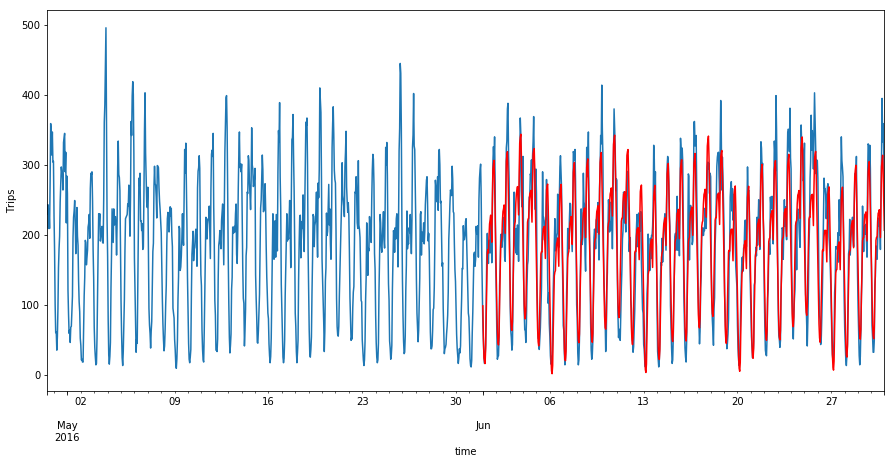

In [758]:
plt.figure(figsize(15,7))
data.trips[-1500:].plot()
new_data.forecast[-1500:].plot(color='r')
plt.ylabel('Trips')
pylab.show()

В целом, выбранная модель прогнозирует адекватно. Наблюдается соблюдение внутрисуточной сезонности, тем самым форма графика приближена к реальным данным. 

Однако имееются большие неточности в прогнозе ввиду того, что неучтены другие признаки, влияющие на количество поездок на такси. Например, праздничные дни и погода.